In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import BayesianGaussianMixture
from nms import nms
from config_voting import *
%matplotlib inline

file_path = '/export/home/qliu24/qing_voting_data/intermediate/feat_pickle/'


oo = 'car'
fname = file_path + 'res_info_' + oo + '_train_carVC.pickle'
print('loading object {0}'.format(oo))
with open(fname, 'rb') as fh:
    layer_feature_dist, _, view_point = pickle.load(fh)
    
asp_ratio = [layer_feature_dist[ii].shape[1]/layer_feature_dist[ii].shape[0] for ii in range(len(layer_feature_dist))]
        
N = len(layer_feature_dist)
print('total number of instances {0}'.format(N))

magic_thh = 0.81

layer_feature_b = [None for nn in range(N)]
for nn in range(N):
    layer_feature_b[nn] = (layer_feature_dist[nn]<magic_thh).astype(int)
    
view_point = np.array(view_point)
idx_s = np.where(np.logical_and(view_point>=67.5,view_point<=112.5))[0]

max_2 = max([layer_feature_b[nn].shape[2] for nn in idx_s])

max_1 = max([layer_feature_b[nn].shape[1] for nn in idx_s])

max_0 = max([layer_feature_b[nn].shape[0] for nn in idx_s])
print(max_0, max_1, max_2)
print(len(idx_s))

loading object car
total number of instances 1000
14 54 158
118


(1000, 158)
(158,)


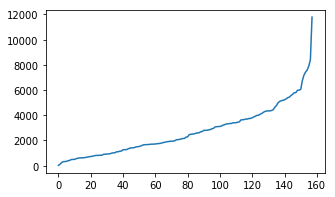

[155 157 131 129 134 110 152 156 139  83 150 117 141 126  69 123 144 132
 130 108  47 146 151 147  50  52 140 138 121  28 105 148  38 128 122 112
 125 107 111  17  86  53 113 118  92 124  63 115  89 120 136 102  73  35
 116  74 135 137  96  30  25  11  94  68 133  22  80  41 145  64 103  45
  43  29  60  99 149 154  91 101 114  59  98  67  56 104 100   3  78  10
  84 119  66  32  75  85  20  27  48  16  37  77 106  49 153  97  34 142
  61  62  87  72  55 127  51  54 143  93  58  88  19  18  71  57  15   4
  79  23 109  90  21   6  46  44  24  95  40  36  12  39  14  82  81  65
  70   9  76   7   8  42   5  31   0  13  33   2   1  26]


In [2]:
# stats of each VC's firing counts (of pixels) in all samples
plt.rcParams['figure.figsize'] = (5.0, 3.0)

vc_count = np.array([np.sum(np.sum(layer_feature_b[nn], axis=0),axis=0) for nn in range(N)])
print(vc_count.shape)
vc_count = np.sum(vc_count, axis=0)
print(vc_count.shape)
plt.plot(np.sort(vc_count))
plt.show()
print(np.argsort(vc_count))

VC idx: 14 Total firing: 7              VC idx: 82 Total firing: 4              VC idx: 81 Total firing: 0              


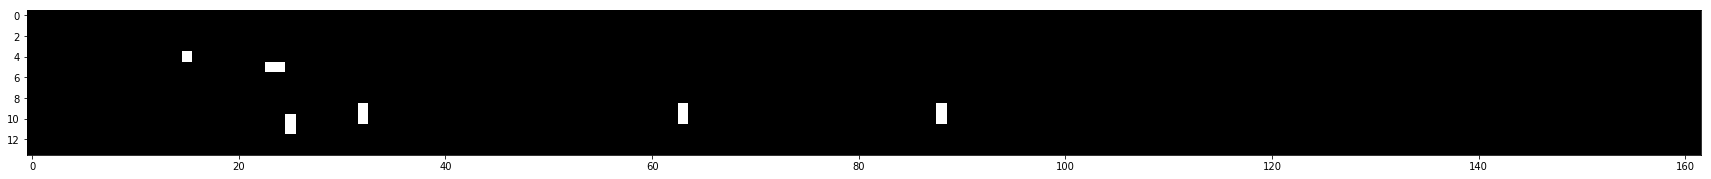

VC idx: 14 Total firing: 4              VC idx: 82 Total firing: 16              VC idx: 81 Total firing: 0              


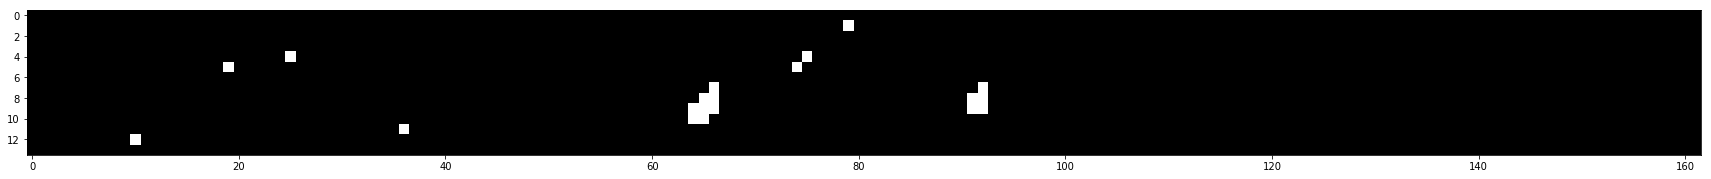

VC idx: 14 Total firing: 9              VC idx: 82 Total firing: 11              VC idx: 81 Total firing: 0              


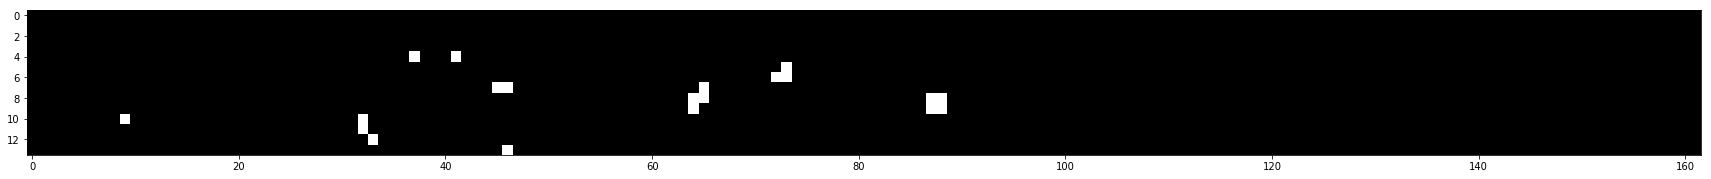

VC idx: 14 Total firing: 5              VC idx: 82 Total firing: 3              VC idx: 81 Total firing: 0              


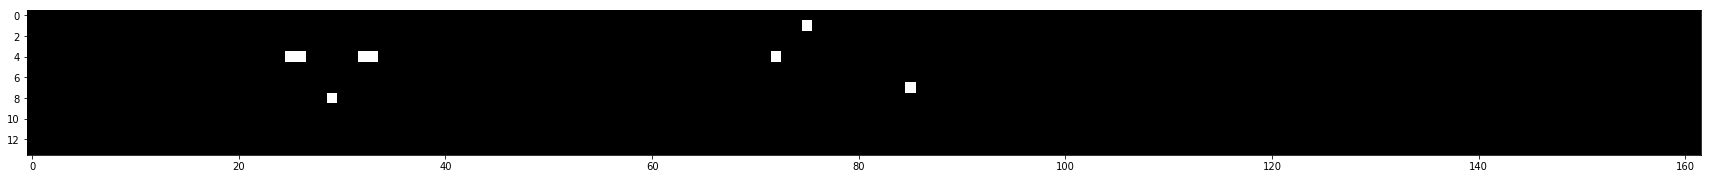

VC idx: 14 Total firing: 6              VC idx: 82 Total firing: 9              VC idx: 81 Total firing: 0              


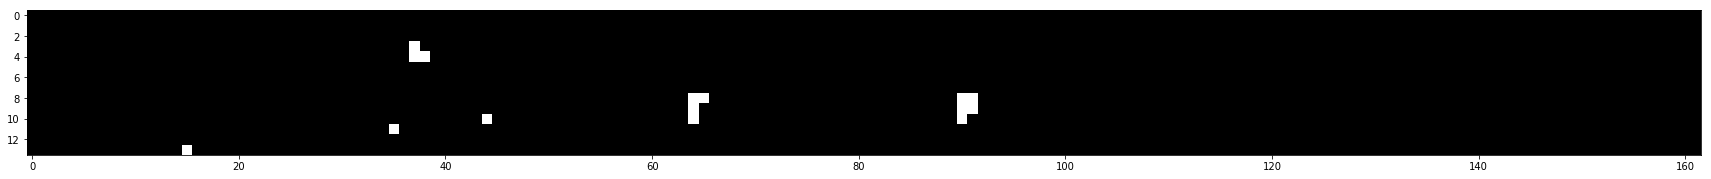

In [69]:
# heatmap of vc firing in specific example
# for nn in np.random.choice(idx_s, 5, replace=False):
for nn in idx_s[0:5]:
    vc_total = 3
    vc_p = np.zeros((max_0, max_1*vc_total))
    for cci,vc_idx in enumerate(np.argsort(vc_count)[-18:-15]):
        print('VC idx: {0}'.format(vc_idx), end=' ')
        vc_l = layer_feature_b[nn][:,:,vc_idx]
        hh, ww = vc_l.shape
        diff_w1 = int((max_1-ww)/2)
        diff_w2 = int(max_1-ww-diff_w1)
        assert(max_1 == diff_w1+diff_w2+ww)

        diff_h1 = int((max_0-hh)/2)
        diff_h2 = int(max_0-hh-diff_h1)
        assert(max_0 == diff_h1+diff_h2+hh)

        padded = np.pad(vc_l, ((diff_h1, diff_h2),(diff_w1, diff_w2)), 'constant', constant_values=0)
        print('Total firing: {}'.format(np.sum(padded)), end='              ')
        vc_p[:,max_1*cci:max_1*(cci+1)] += padded
        
    print('')
    plt.rcParams['figure.figsize'] = (30.0, 30.0) # set default size of plots
    plt.rcParams['image.interpolation'] = 'nearest'
    plt.rcParams['image.cmap'] = 'gray'
    fig, ax = plt.subplots()
    # ax.imshow(mean_acr_vc.T)
    ax.imshow(vc_p)
    plt.show()

In [5]:
layer_fire_nms = [np.zeros_like(layer_feature_b[nn]) for nn in idx_s]
for nni,nn in enumerate(idx_s):
    for vc_i in range(max_2):
        ri, ci = np.where(layer_feature_b[nn][:,:,vc_i]==1)
        if ri.size==0:
            continue
        
        r_list = Astride * ri + Arf/2 - Apad
        c_list = Astride * ci + Arf/2 - Apad
        bb_loc = np.column_stack([c_list-Arf/2, r_list-Arf/2, c_list+Arf/2, r_list+Arf/2])
        det = layer_feature_dist[nn][ri,ci,vc_i]
        
        bb_loc_ = np.column_stack([bb_loc, -det])
        nms_list = nms(bb_loc_, 0.05)
        layer_fire_nms[nni][ri[nms_list], ci[nms_list], vc_i] = 1
        

VC idx: 2 Total firing: 2              VC idx: 1 Total firing: 2              VC idx: 26 Total firing: 3              


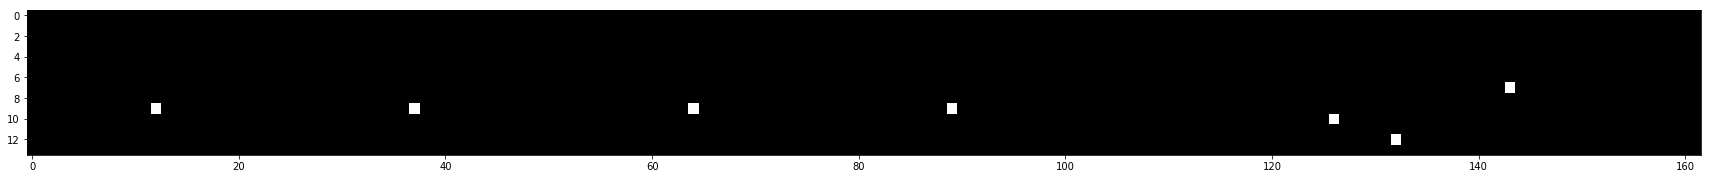

VC idx: 2 Total firing: 2              VC idx: 1 Total firing: 2              VC idx: 26 Total firing: 1              


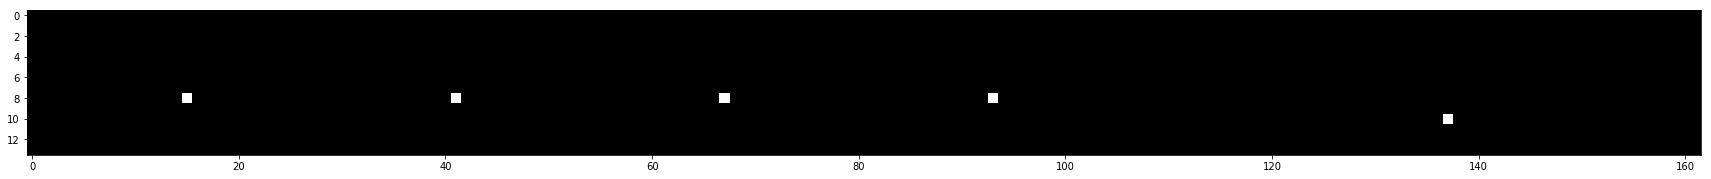

VC idx: 2 Total firing: 2              VC idx: 1 Total firing: 2              VC idx: 26 Total firing: 6              


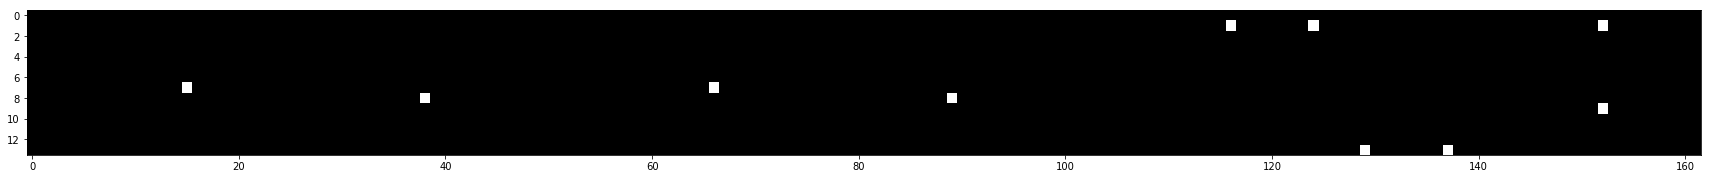

VC idx: 2 Total firing: 1              VC idx: 1 Total firing: 1              VC idx: 26 Total firing: 1              


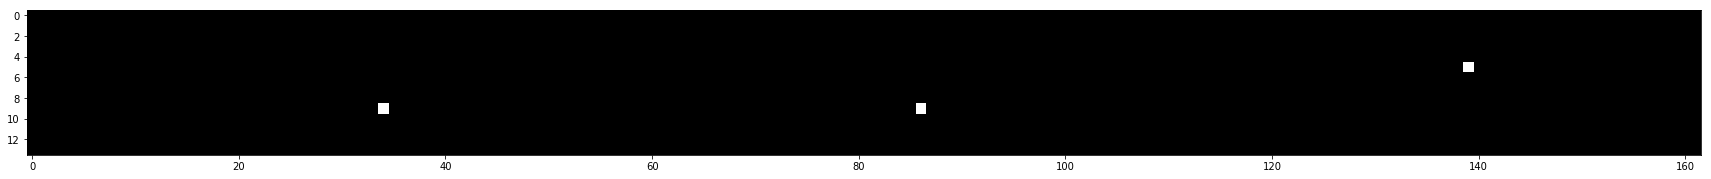

VC idx: 2 Total firing: 2              VC idx: 1 Total firing: 2              VC idx: 26 Total firing: 2              


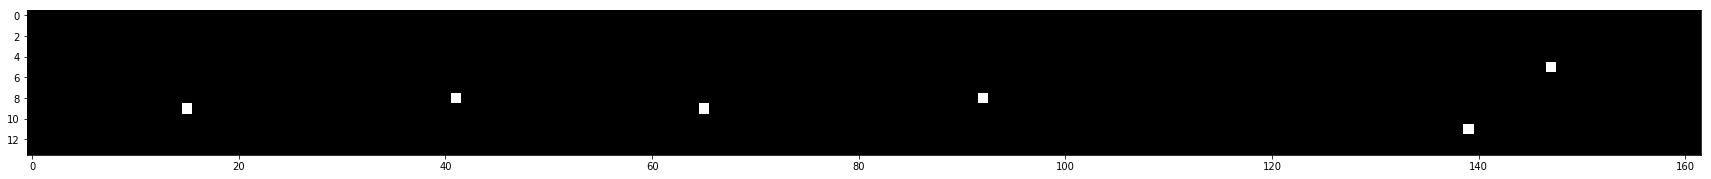

In [7]:
for nn in range(5):
    vc_total = 3
    vc_p = np.zeros((max_0, max_1*vc_total))
    for cci,vc_idx in enumerate(np.argsort(vc_count)[-3:]):
        print('VC idx: {0}'.format(vc_idx), end=' ')
        vc_l = layer_fire_nms[nn][:,:,vc_idx]
        hh, ww = vc_l.shape
        diff_w1 = int((max_1-ww)/2)
        diff_w2 = int(max_1-ww-diff_w1)
        assert(max_1 == diff_w1+diff_w2+ww)

        diff_h1 = int((max_0-hh)/2)
        diff_h2 = int(max_0-hh-diff_h1)
        assert(max_0 == diff_h1+diff_h2+hh)

        padded = np.pad(vc_l, ((diff_h1, diff_h2),(diff_w1, diff_w2)), 'constant', constant_values=0)
        print('Total firing: {}'.format(np.sum(padded)), end='              ')
        vc_p[:,max_1*cci:max_1*(cci+1)] += padded
        
    print('')
    plt.rcParams['figure.figsize'] = (30.0, 30.0) # set default size of plots
    plt.rcParams['image.interpolation'] = 'nearest'
    plt.rcParams['image.cmap'] = 'gray'
    fig, ax = plt.subplots()
    # ax.imshow(mean_acr_vc.T)
    ax.imshow(vc_p)
    plt.show()

In [8]:
from copy import *
import scipy.io as sio

dir_img = Dataset['img_dir'].format(oo)
dir_anno = Dataset['anno_dir'].format(oo)
file_list = Dataset['{0}_list'.format('train')].format(oo)
assert(os.path.isfile(file_list))
with open(file_list, 'r') as fh:
    content = fh.readlines()

img_list = [x.strip().split() for x in content]
img_num = len(img_list)

img_all = []
for nn in idx_s:
    file_img = os.path.join(dir_img, '{0}.JPEG'.format(img_list[nn][0]))
    assert(os.path.isfile(file_img))
    img = cv2.imread(file_img)
    height, width = img.shape[0:2]
    
    file_anno = os.path.join(dir_anno, '{0}.mat'.format(img_list[nn][0]))
    assert(os.path.isfile(file_anno))
    mat_contents = sio.loadmat(file_anno)
    record = mat_contents['record']
    objects = record['objects']
    bbox = objects[0,0]['bbox'][0,int(img_list[nn][1])-1][0]
    bbox = [max(math.ceil(bbox[0]), 1), max(math.ceil(bbox[1]), 1), \
            min(math.floor(bbox[2]), width), min(math.floor(bbox[3]), height)]
    patch = img[bbox[1]-1: bbox[3], bbox[0]-1: bbox[2], :]
    patch = myresize(patch, scale_size, 'short')
    img_all.append(deepcopy(patch))
    
print(len(img_all))

118


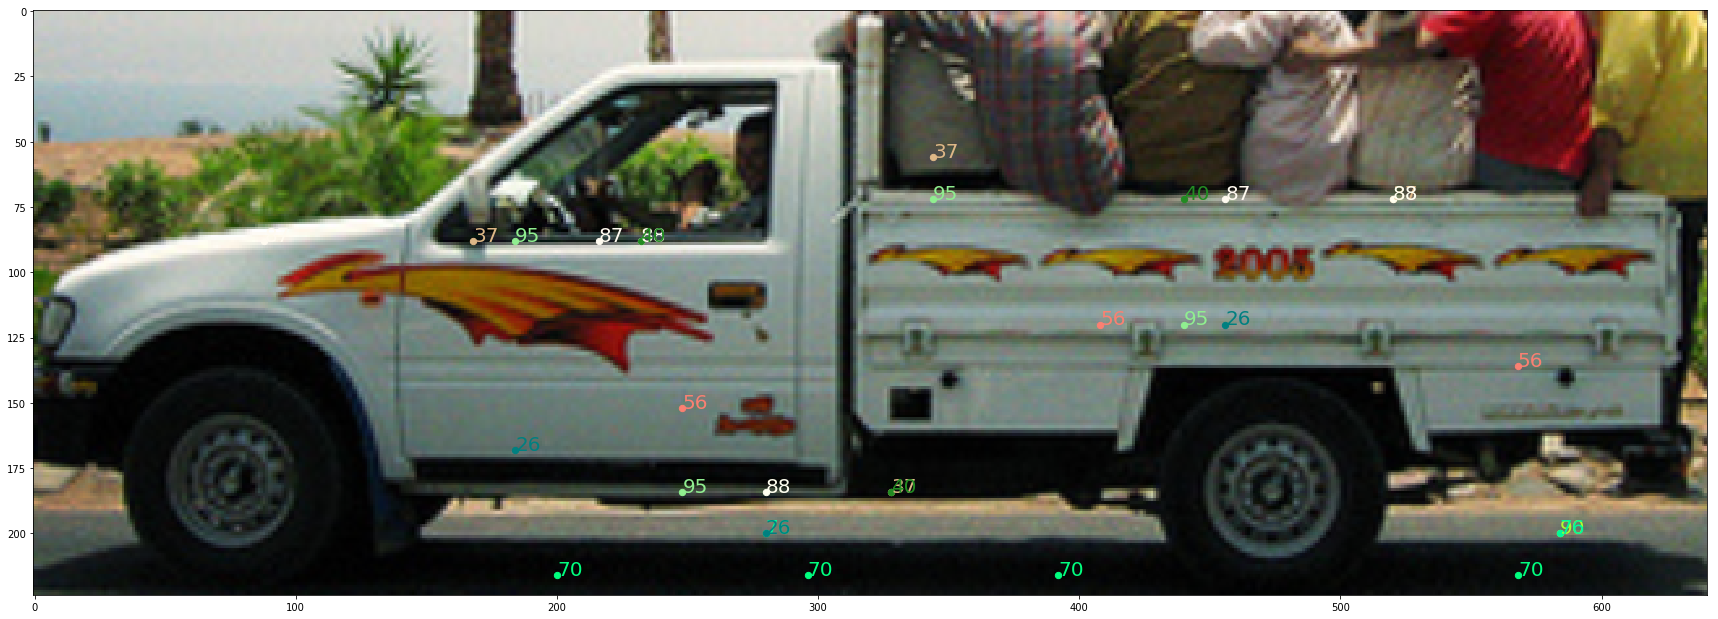

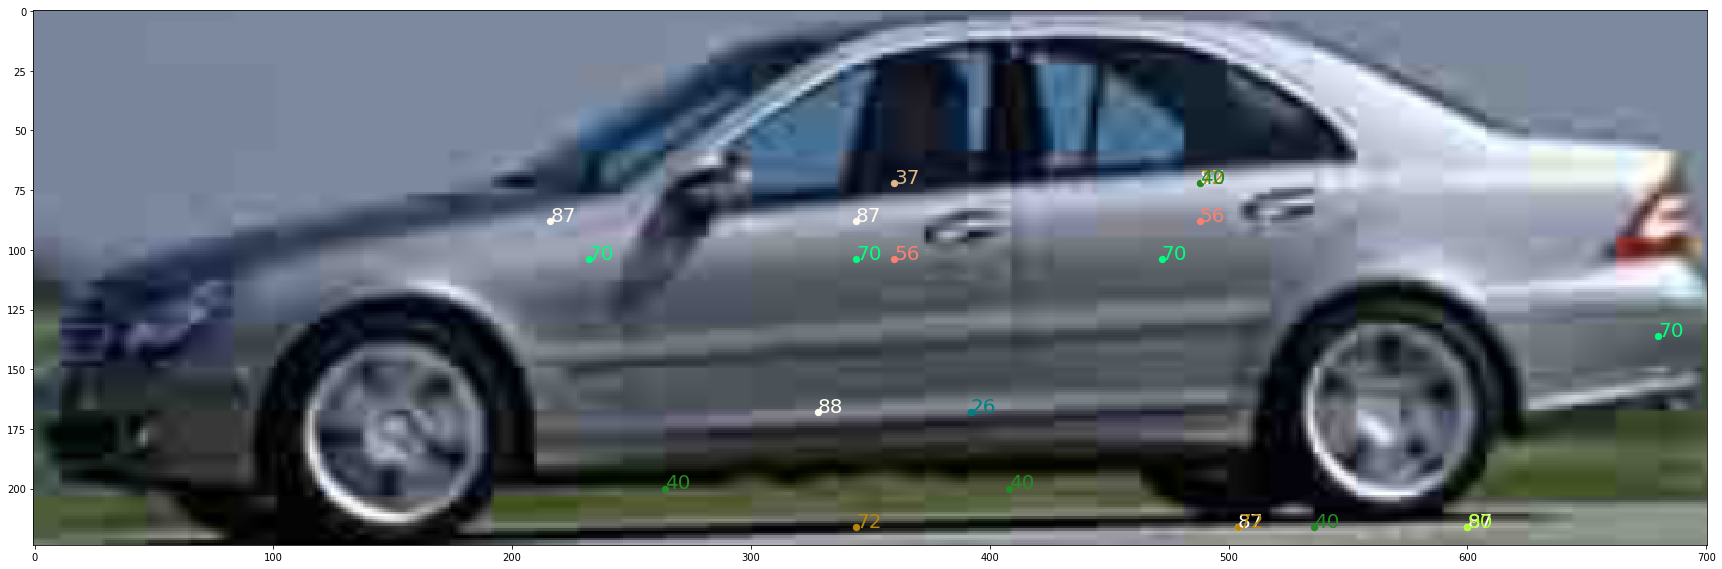

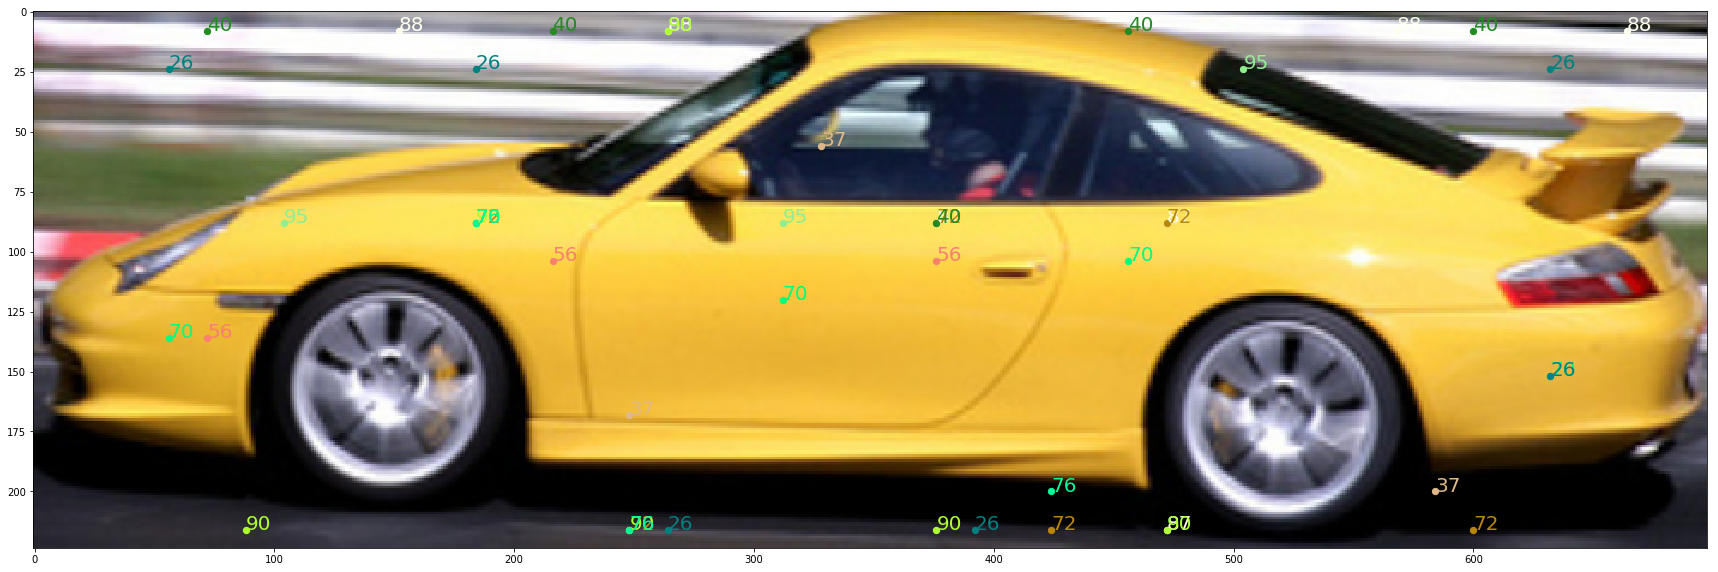

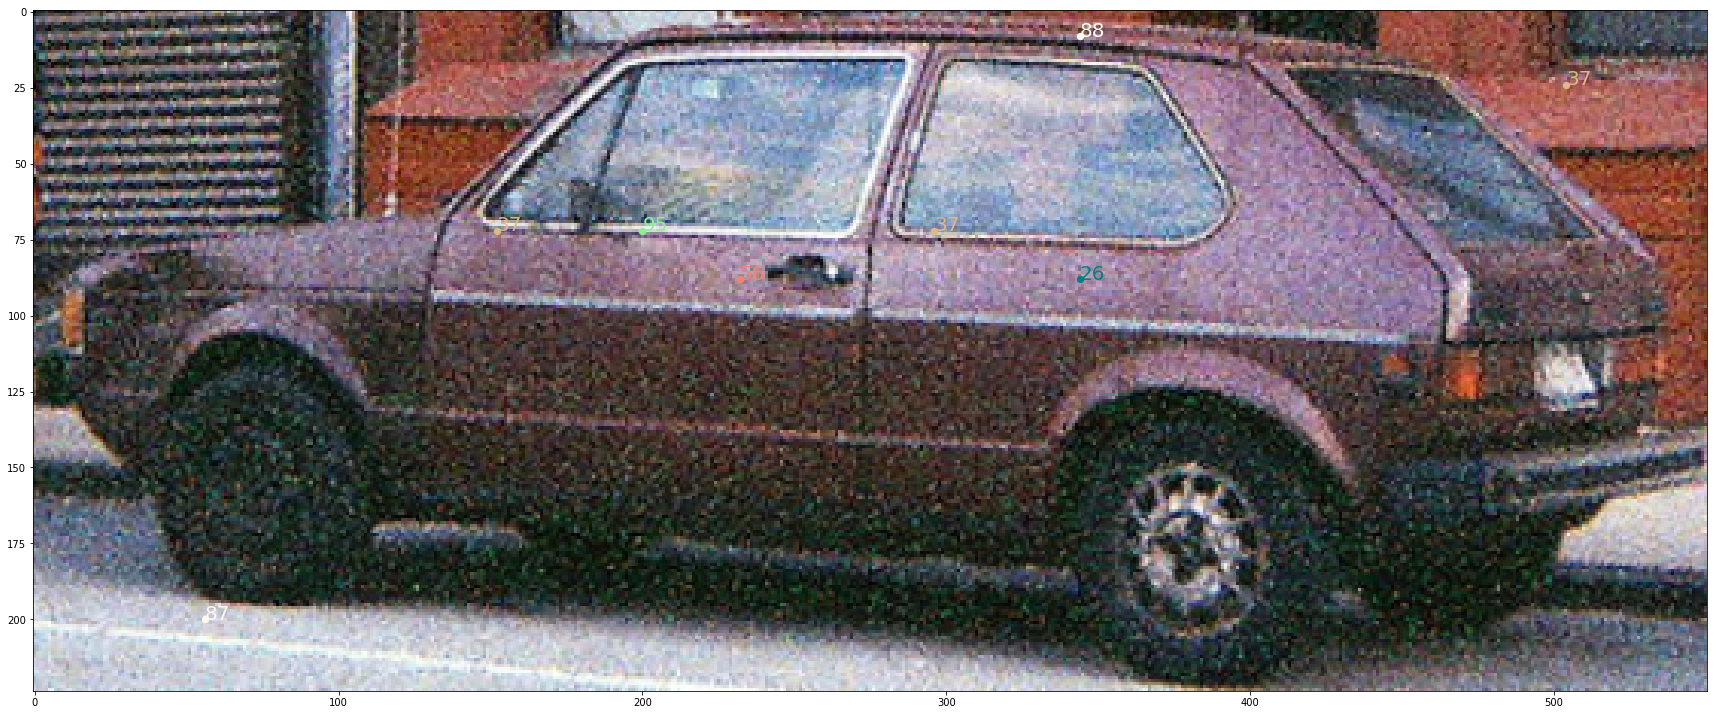

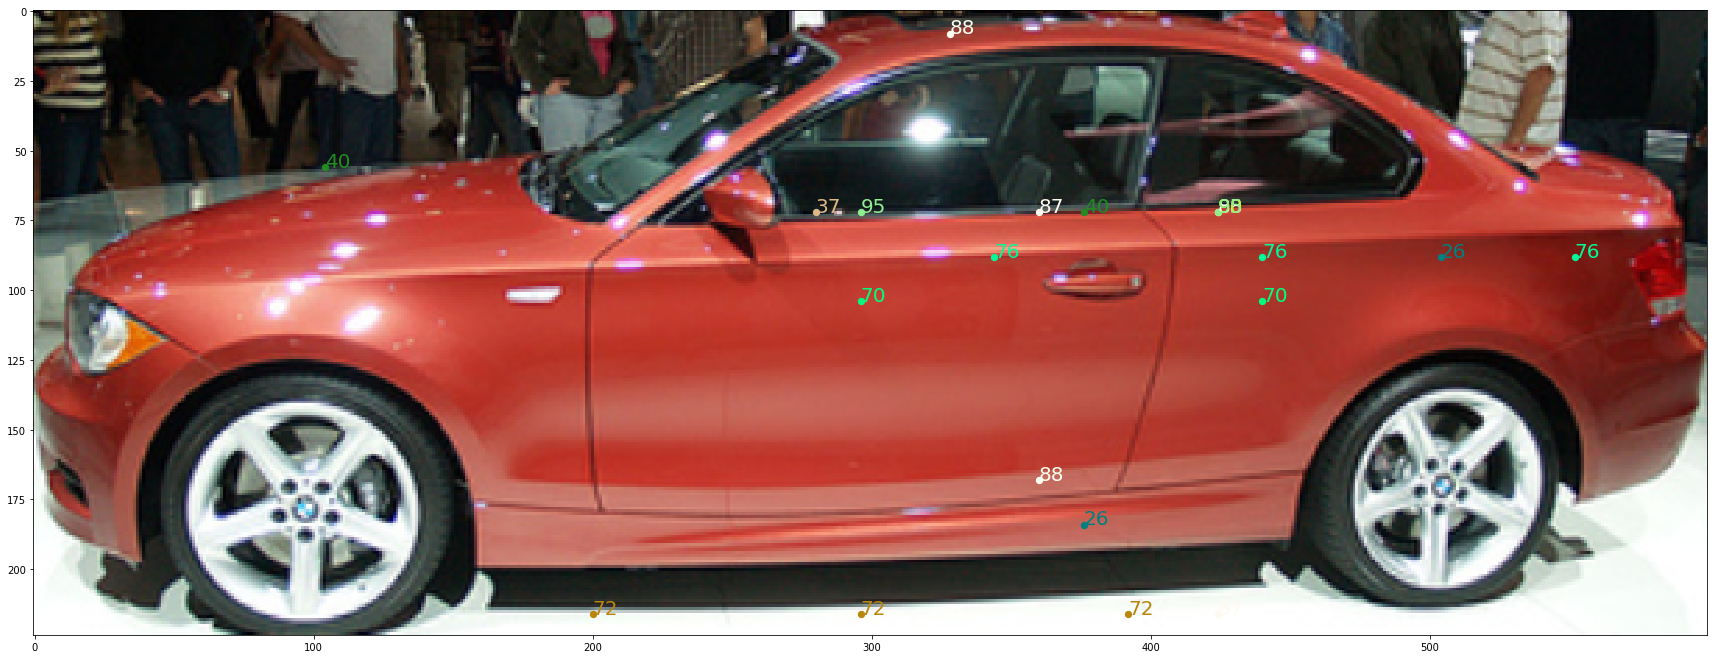

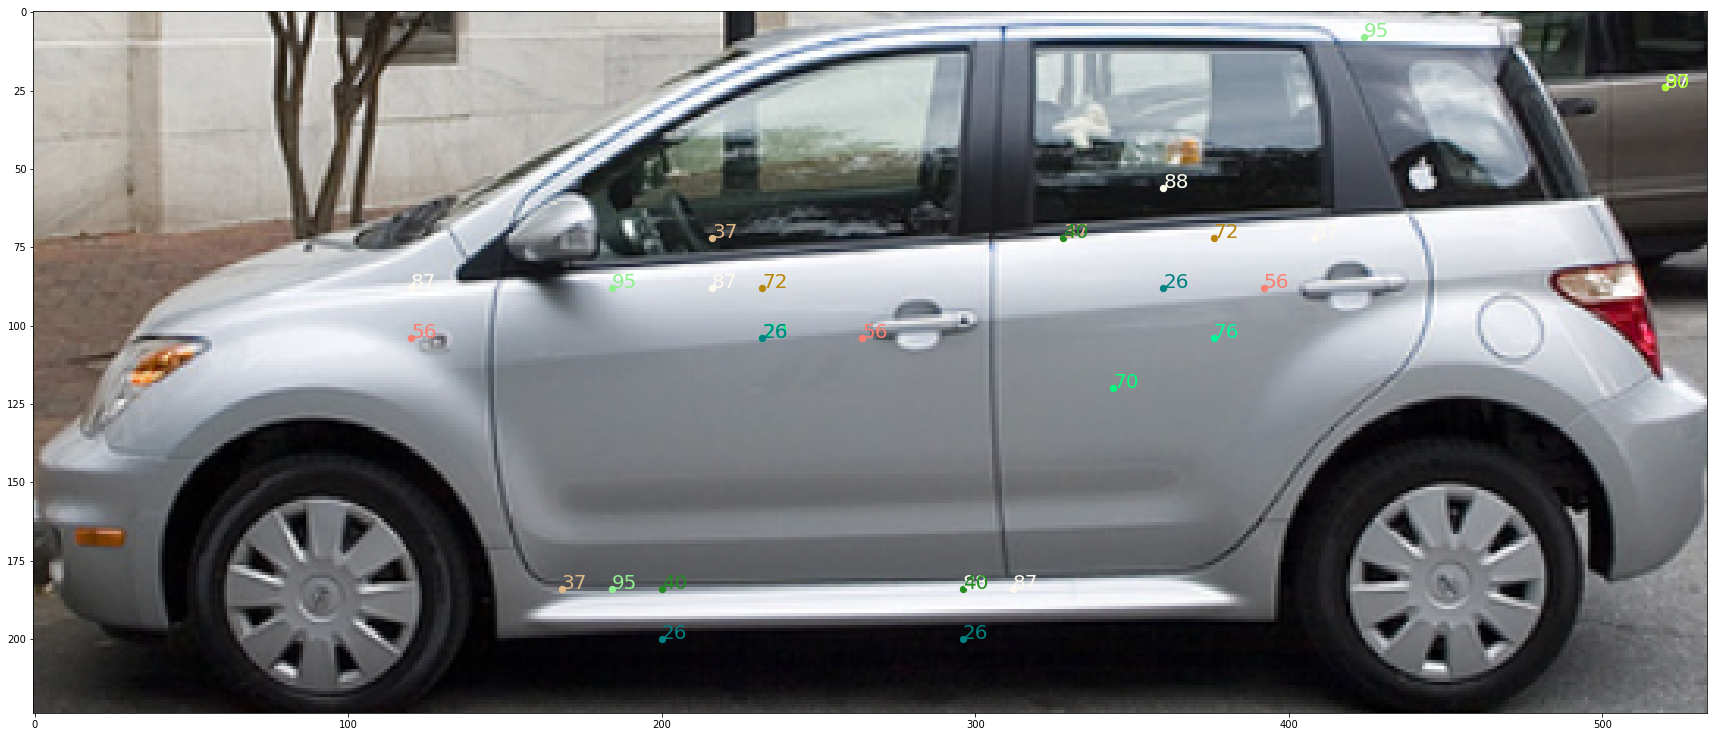

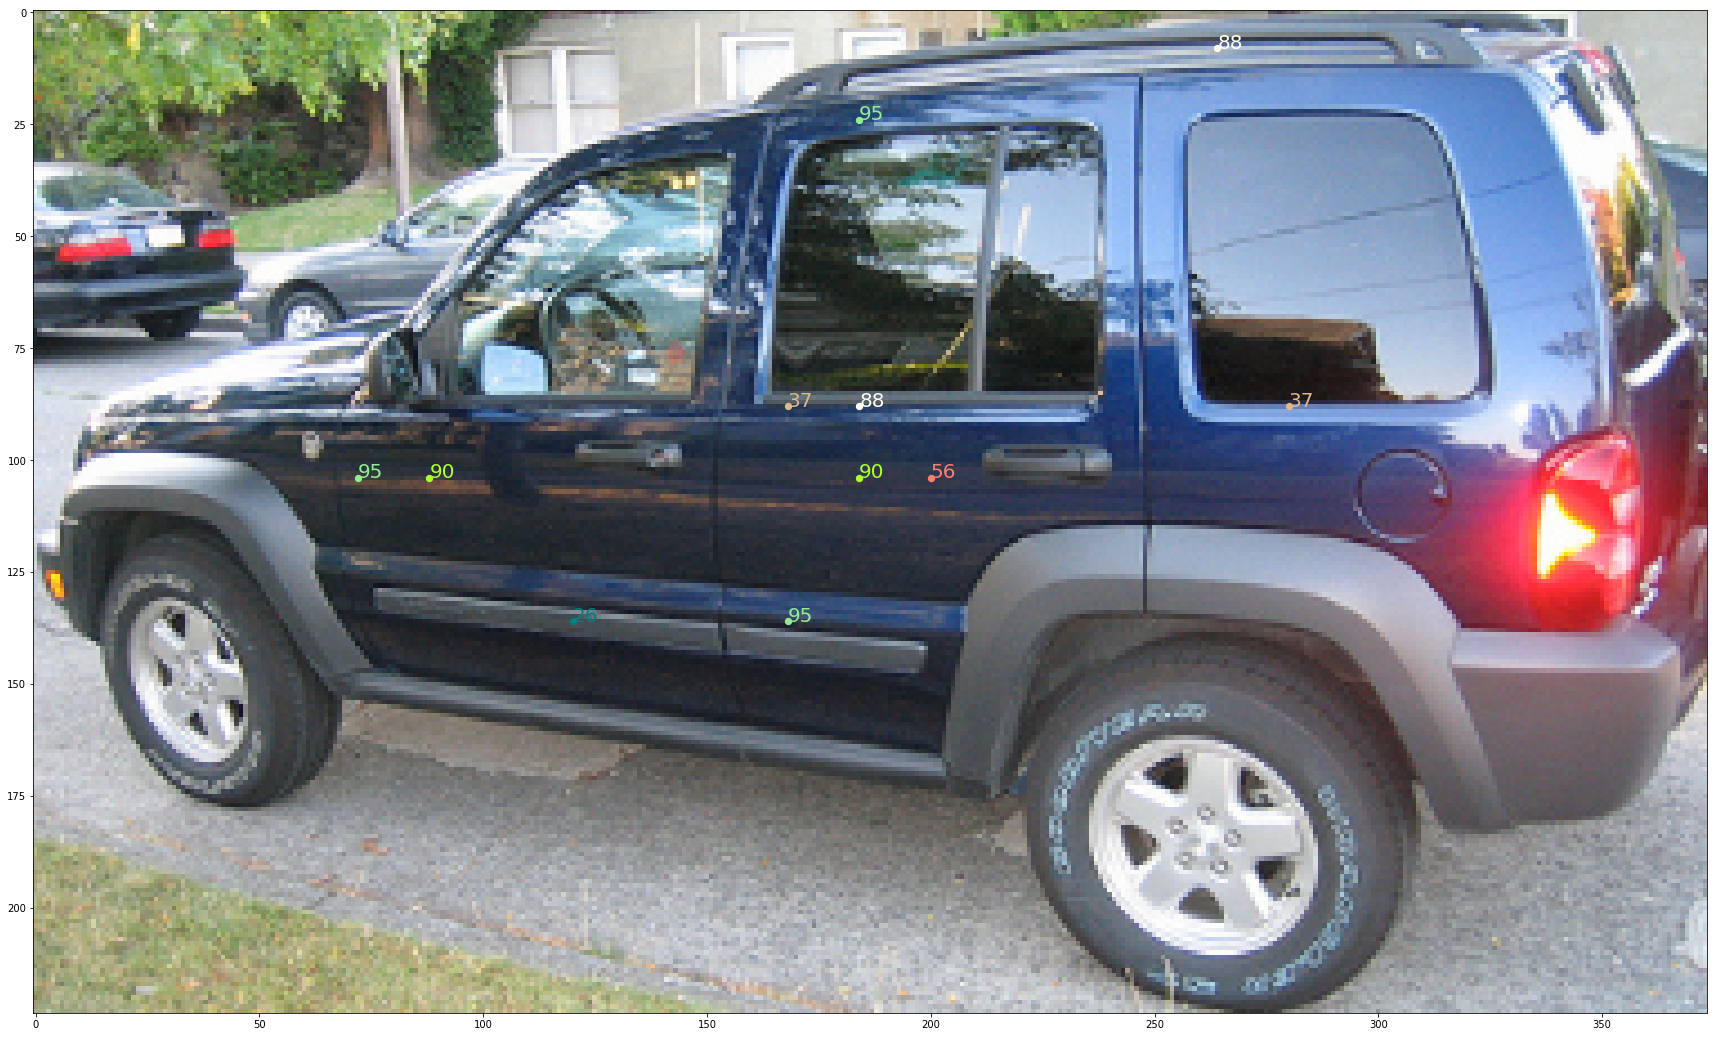

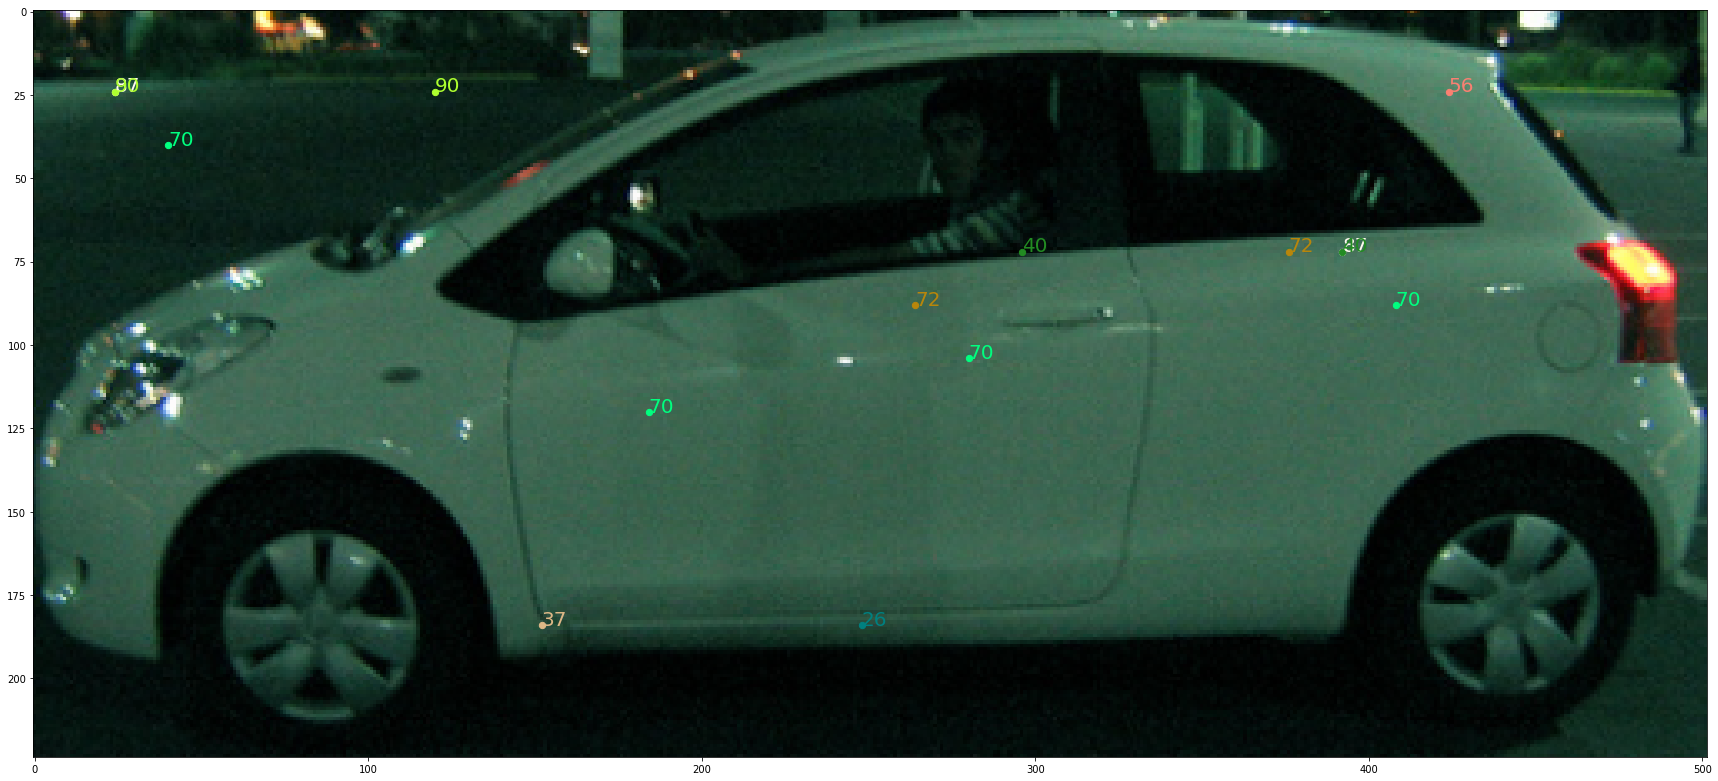

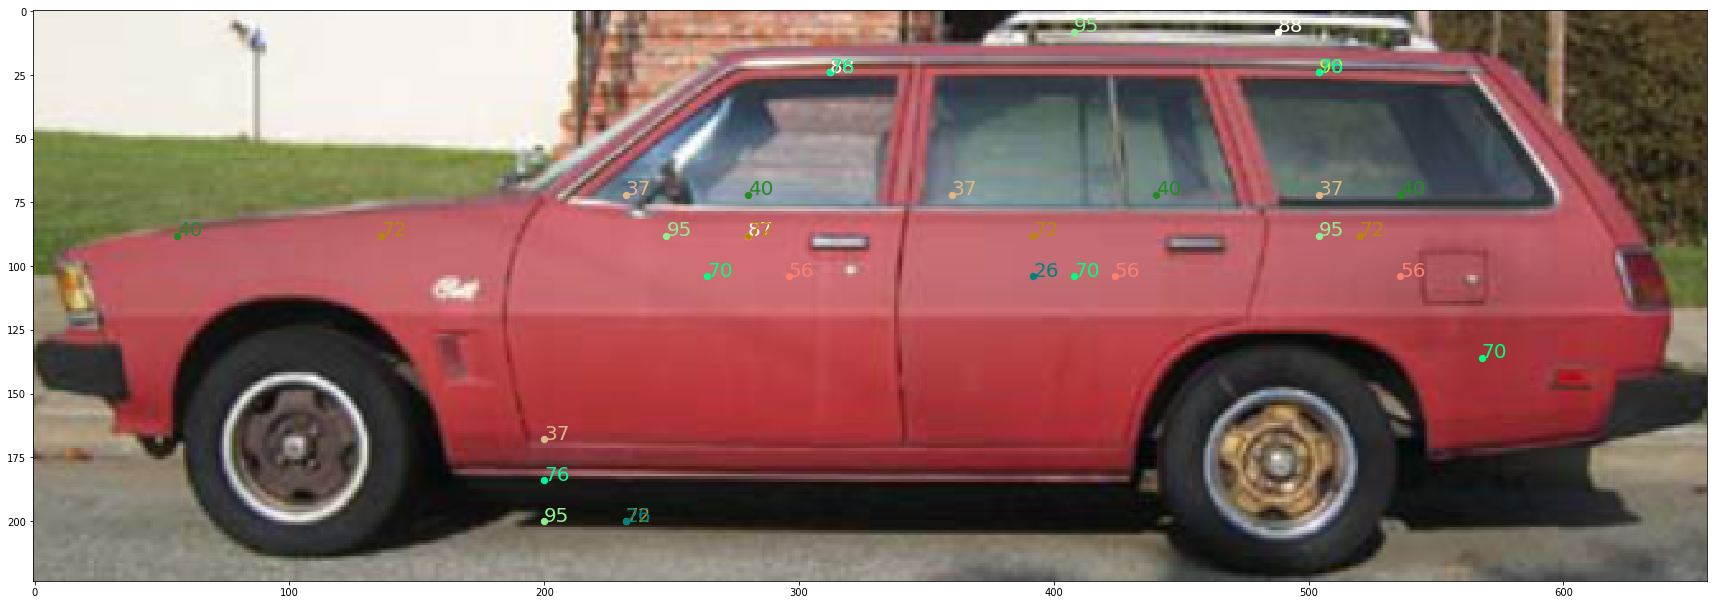

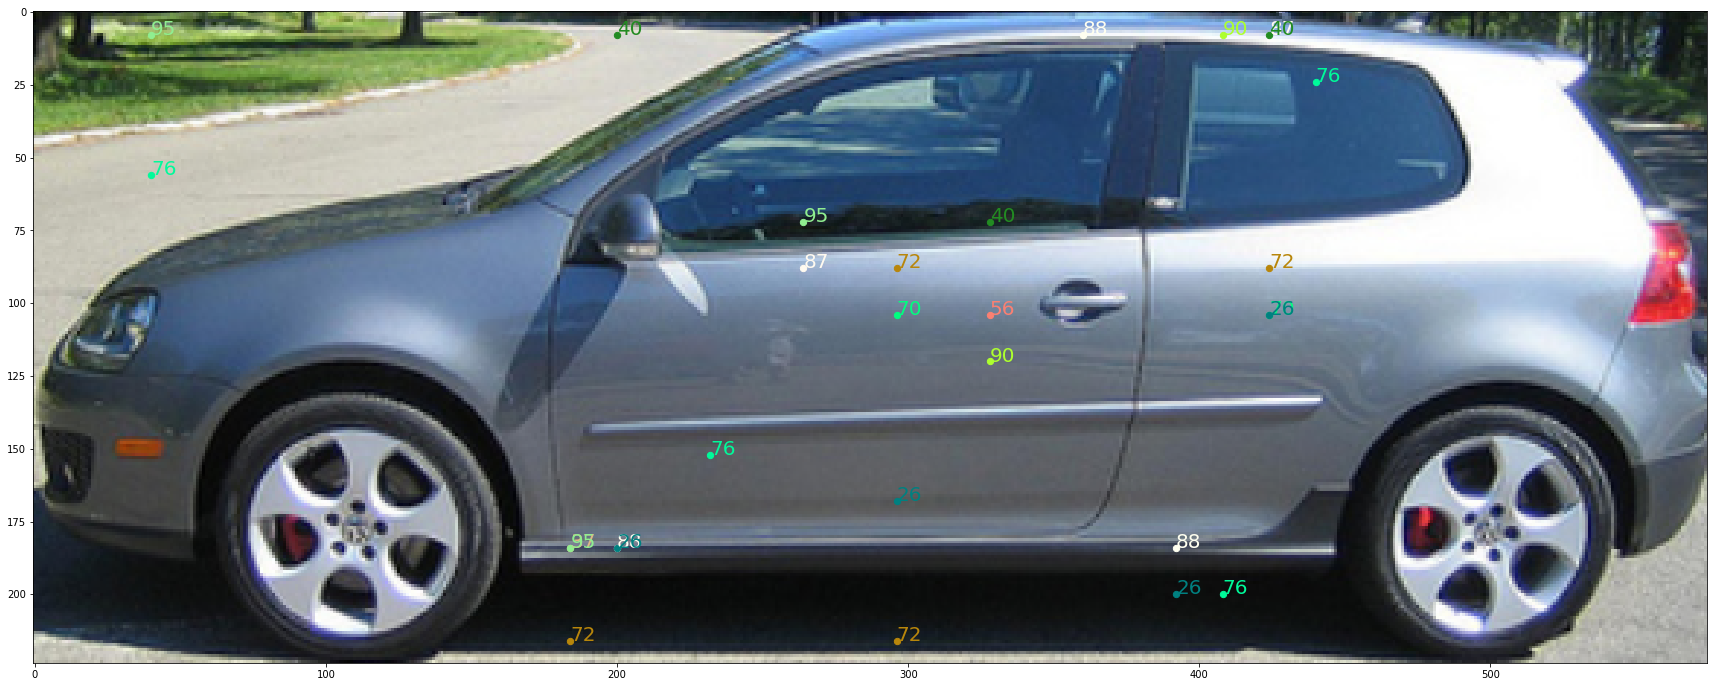

In [32]:
from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgba(color)[:3])), name)
                for name, color in colors.items())
sorted_names = [name for hsv, name in by_hsv]

plt.rcParams['figure.figsize'] = (30.0, 30.0)
# f,ax = plt.subplots(10,1)
for img_i in range(10):
    f,ax = plt.subplots()
    ax.imshow(img_all[img_i][:,:,::-1])

    for ii,vc_i in enumerate(np.argsort(vc_count)[-100:]):
        if vc_i not in [76,90,26,37,95,70,88,56,72,87,40]:
            continue
            
        vc_l = layer_fire_nms[img_i][:,:,vc_i]

        ri, ci = np.where(vc_l==1)
        if ri.size==0:
            continue

        r_list = Astride * ri + Arf/2 - Apad
        c_list = Astride * ci + Arf/2 - Apad
        for ri in range(len(r_list)):
            ax.scatter(c_list[ri], r_list[ri], c=colors[sorted_names[ii]], s=40)
            ax.annotate(str(vc_i), (c_list[ri], r_list[ri]), fontsize=20, color=colors[sorted_names[ii]])
            
    plt.show()

# plt.savefig('car_fixV_VC_test_carVC.png')


In [19]:
def min_dist(ls1, ls2):
    dd_min = 999999
    for pos1 in zip(ls1[0], ls1[1]):
        for pos2 in zip(ls2[0], ls2[1]):
            dd = np.linalg.norm(np.array(pos1)-np.array(pos2))
            if dd < dd_min:
                dd_min = dd
                
    return dd_min
    

vc_pw_dist = [np.ones((max_2, max_2)) * 999 for nn in range(len(idx_s))]
for img_n in range(len(idx_s)):
    for vc_i in range(max_2):
        vc_il = layer_fire_nms[img_n][:,:,vc_i]
        ri, ci  = np.where(vc_il==1)
        if ri.size==0:
            continue
            
        for vc_j in range(vc_i+1, max_2):
            vc_jl = layer_fire_nms[img_n][:,:,vc_j]
            rj, cj  = np.where(vc_jl==1)
            if rj.size==0:
                continue
                
            vc_pw_dist[img_n][vc_i, vc_j] = min_dist([ri, ci], [rj, cj])
            
    vc_pw_dist[img_n] = np.minimum(vc_pw_dist[img_n], vc_pw_dist[img_n].T)  # symmetrize the matrix
    

print(vc_pw_dist[len(idx_s)-1])
            
    

[[ 999.            2.23606798    0.         ...,  999.          999.          999.        ]
 [   2.23606798  999.            2.         ...,  999.          999.          999.        ]
 [   0.            2.          999.         ...,  999.          999.          999.        ]
 ..., 
 [ 999.          999.          999.         ...,  999.          999.          999.        ]
 [ 999.          999.          999.         ...,  999.          999.          999.        ]
 [ 999.          999.          999.         ...,  999.          999.          999.        ]]


In [80]:
vc_i = 66
count_arr = np.zeros(max_2)
for img_n in range(len(idx_s)):
    count_arr += vc_pw_dist[img_n][vc_i,:] <= 4
    
vc_ls = np.where(count_arr >= 60)[0]
vc_ls = np.append(vc_ls, vc_i)
print(vc_ls)

[ 42  57  95 143  66]


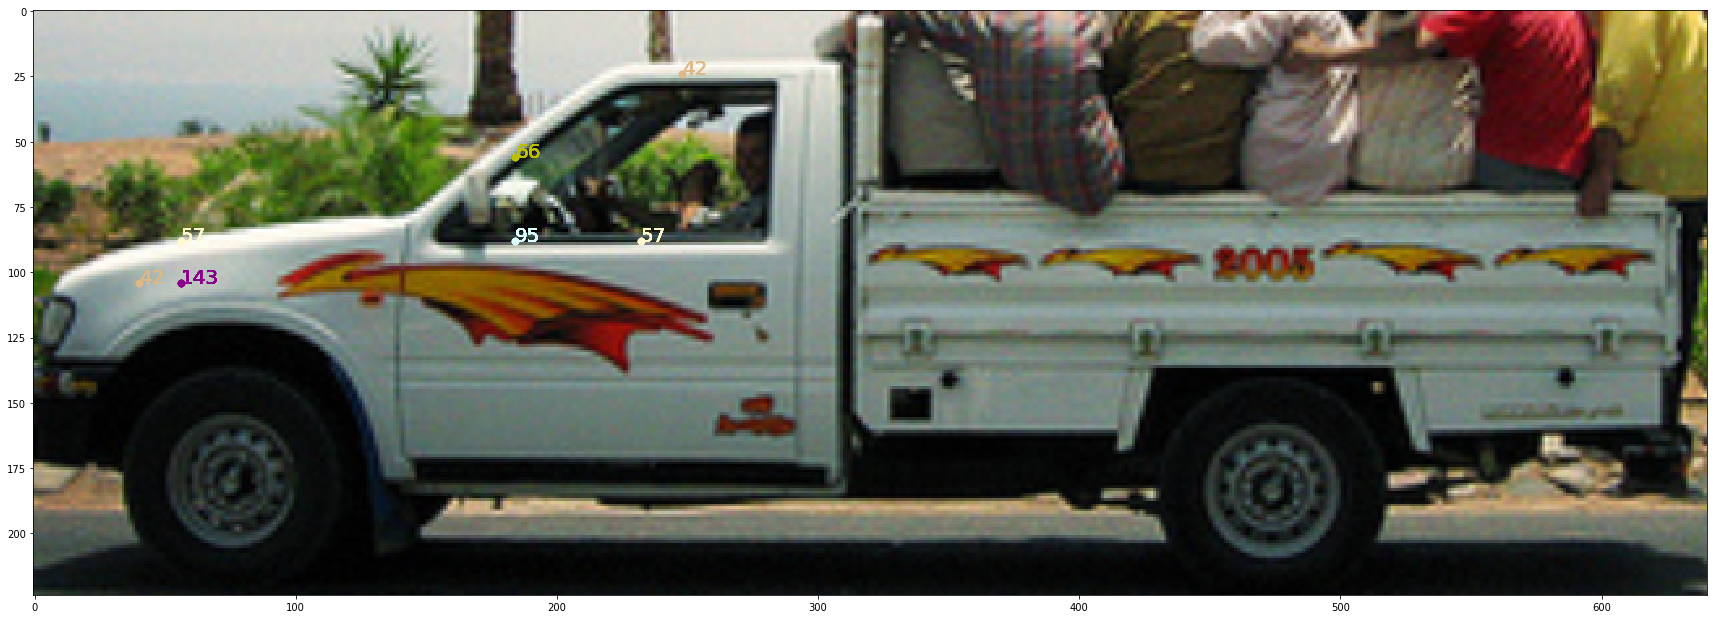

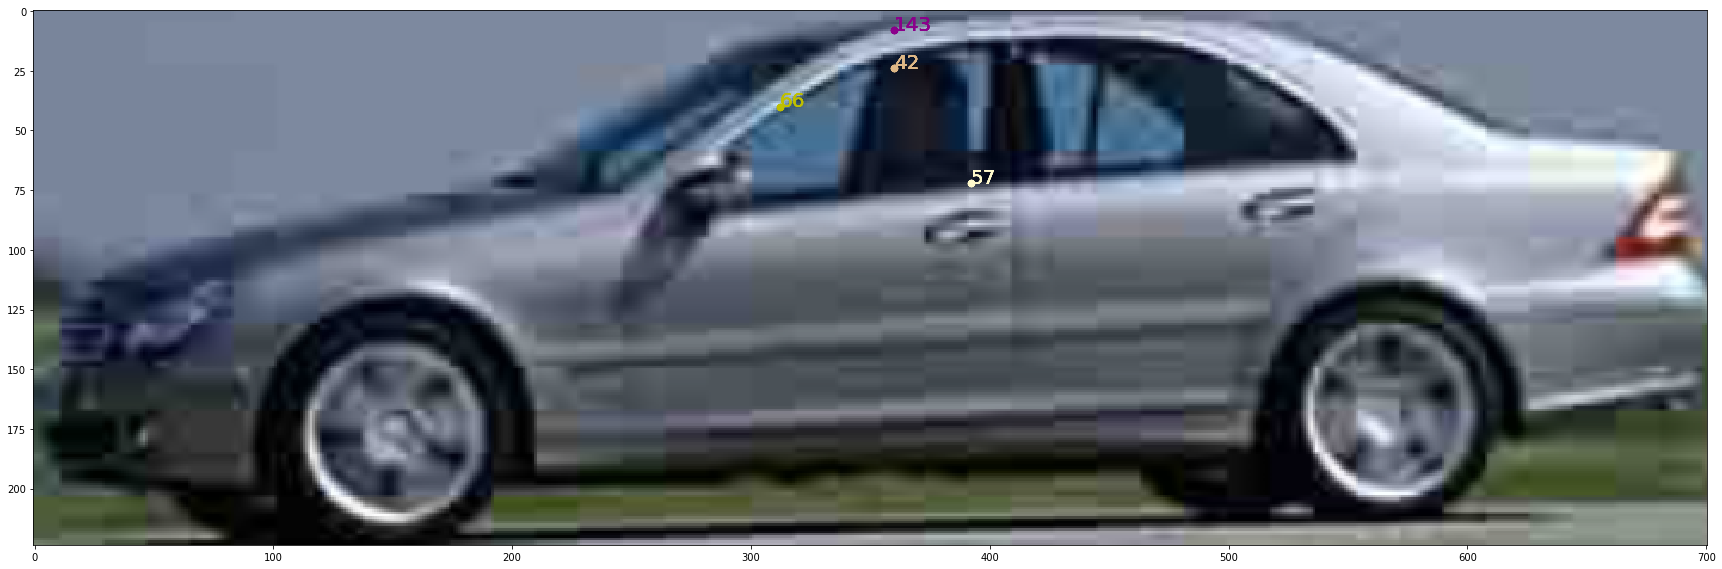

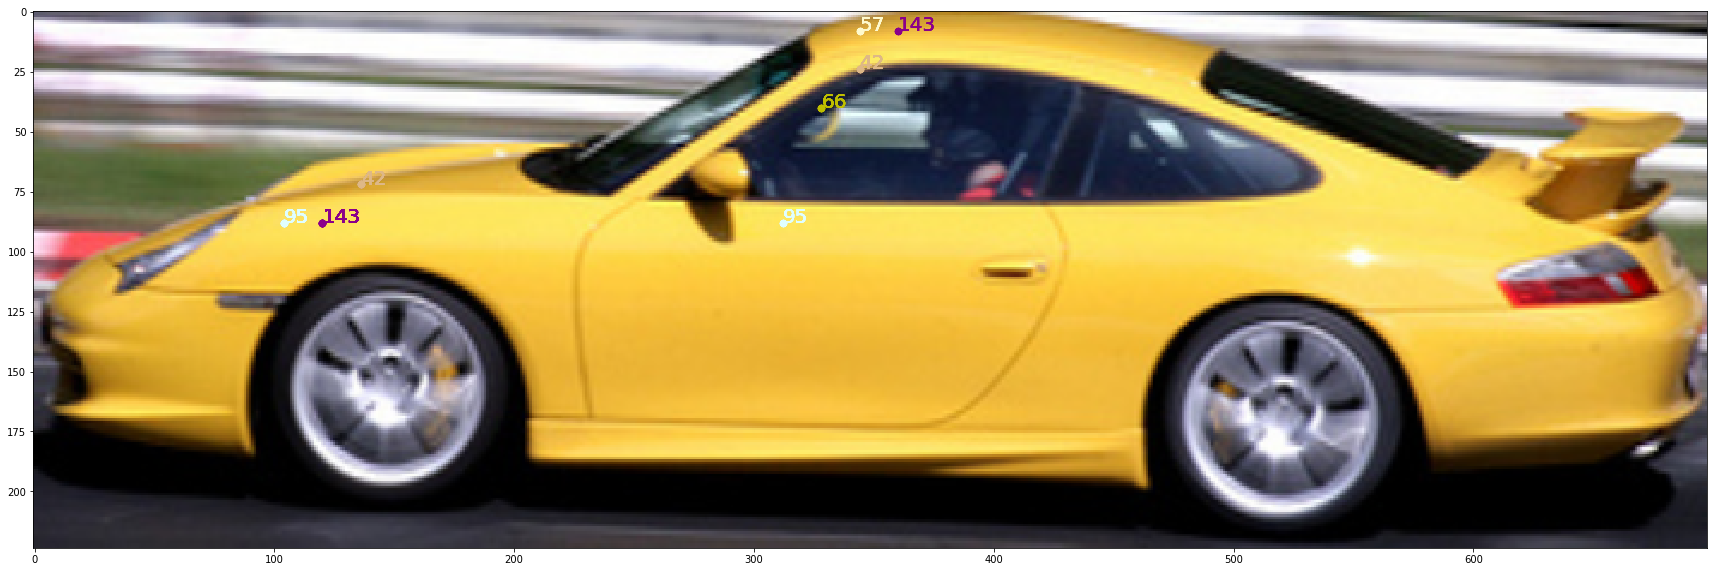

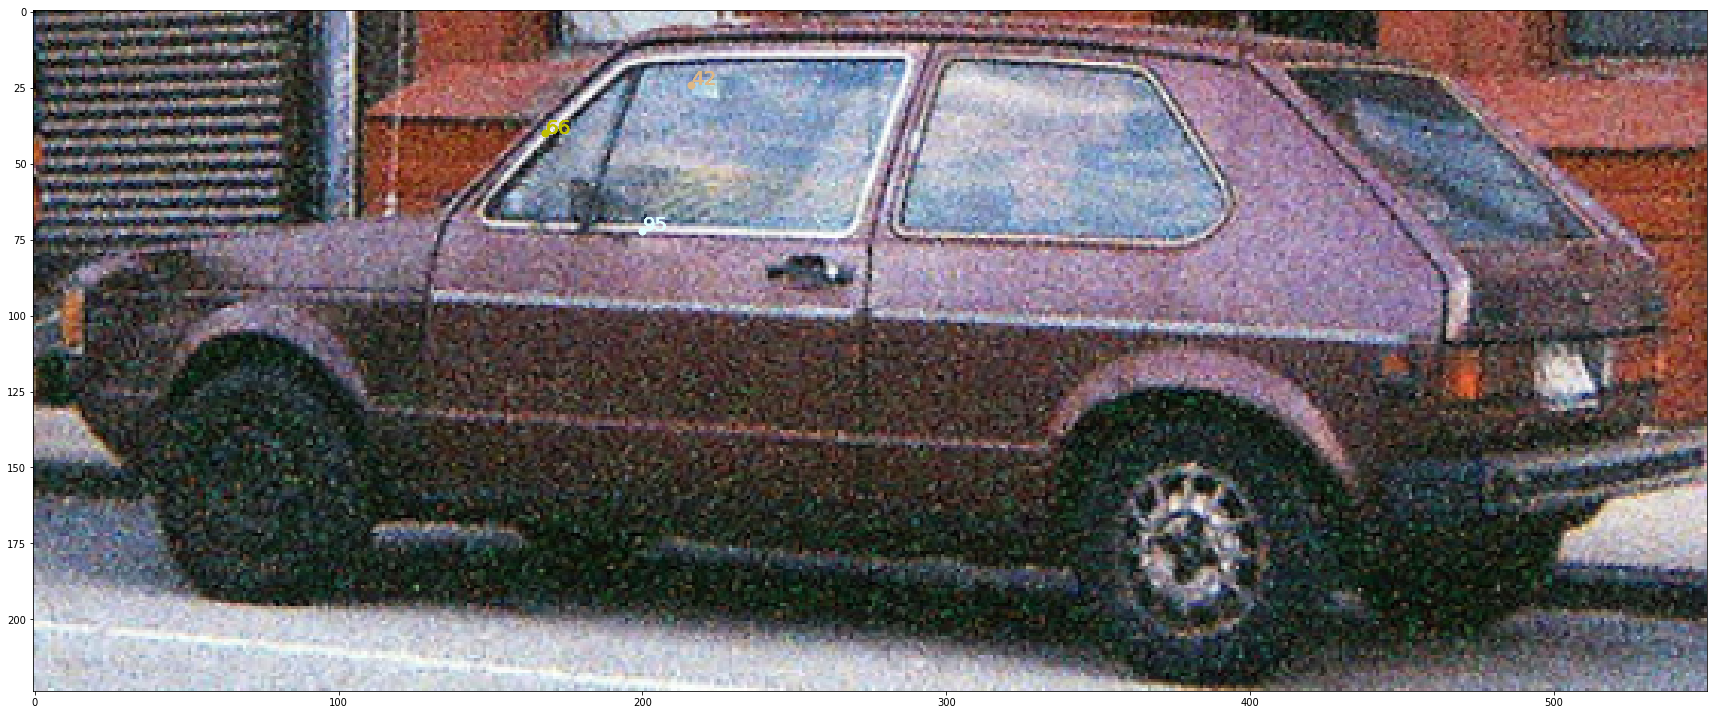

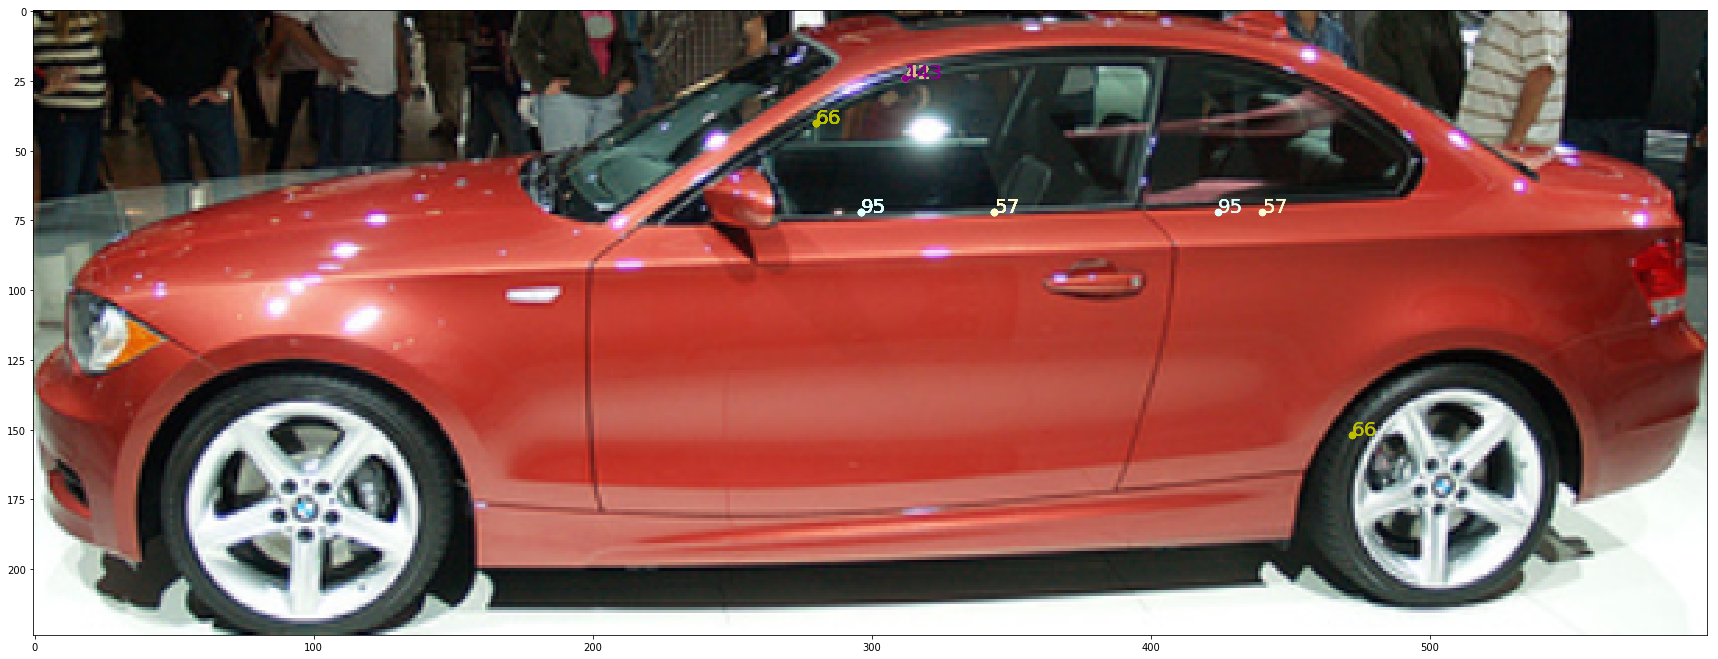

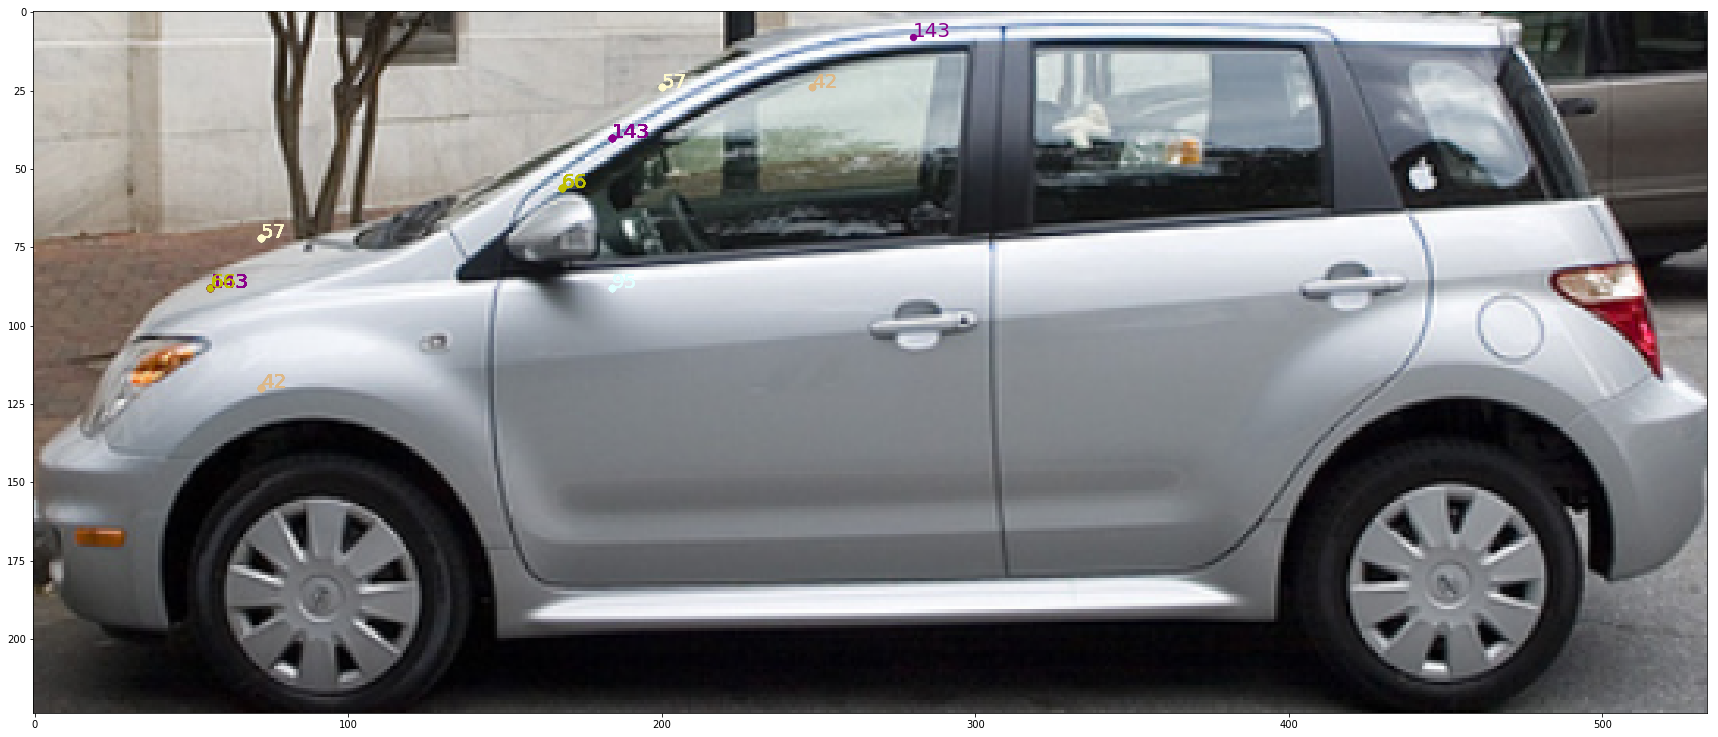

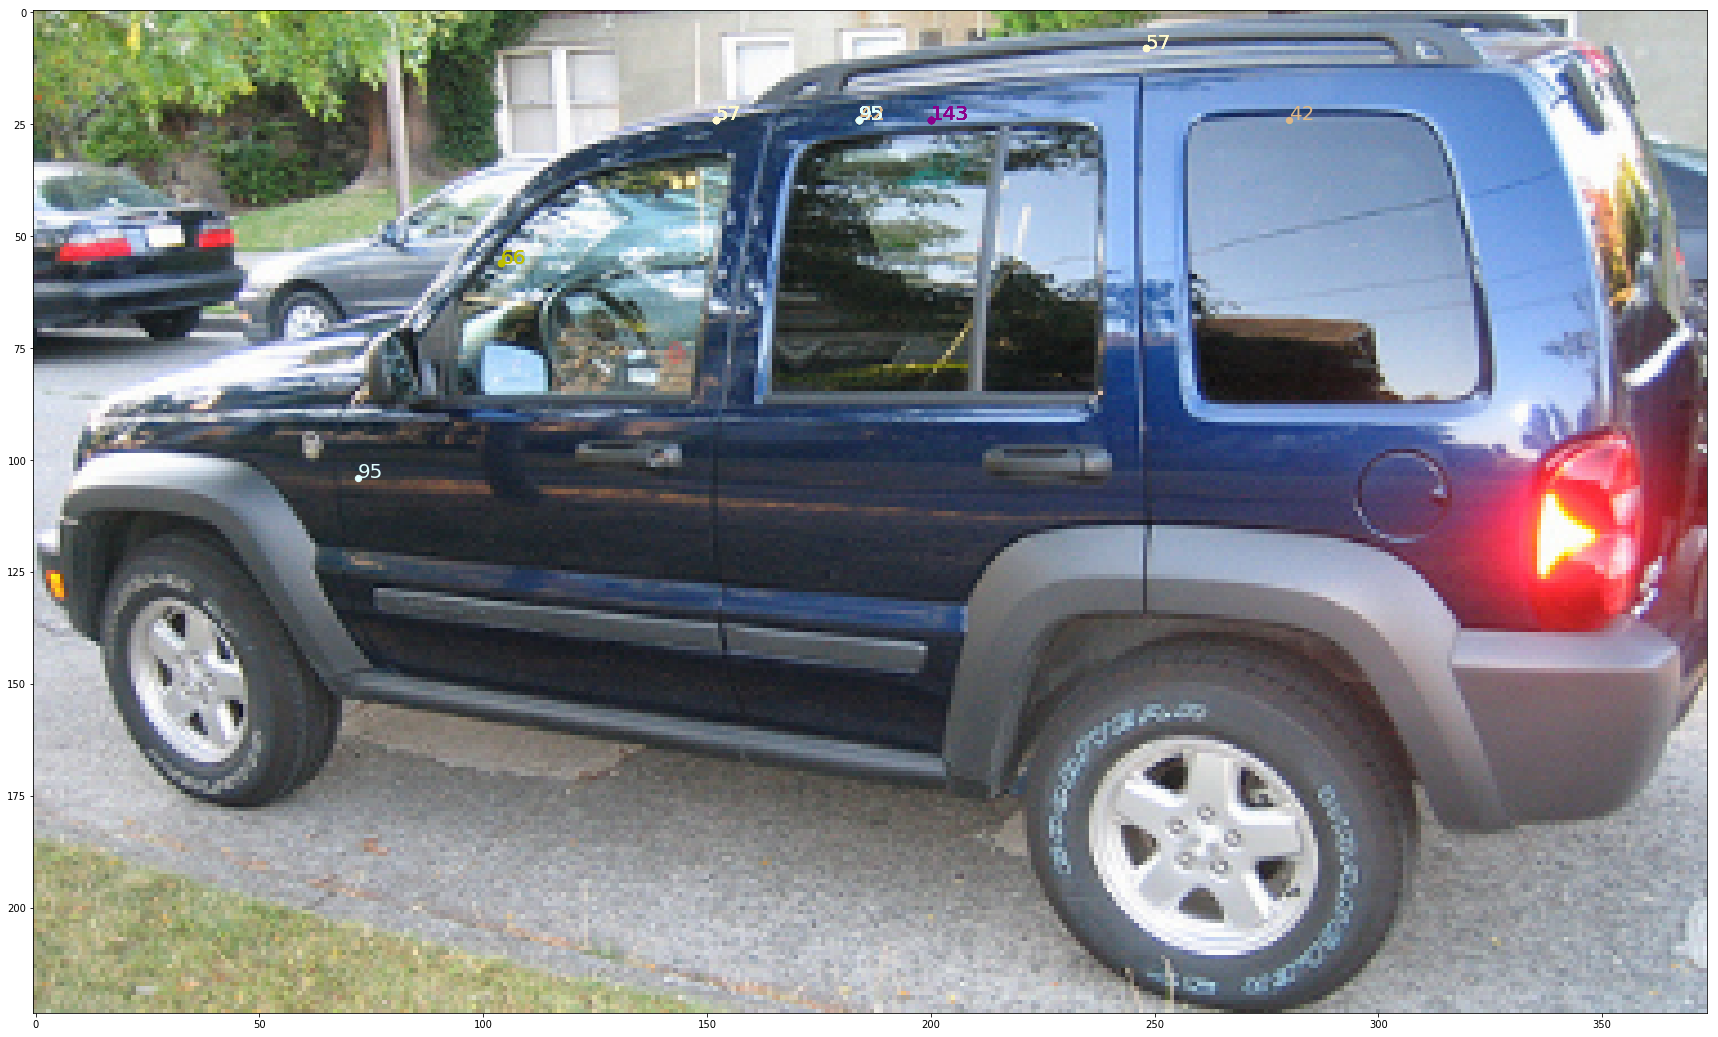

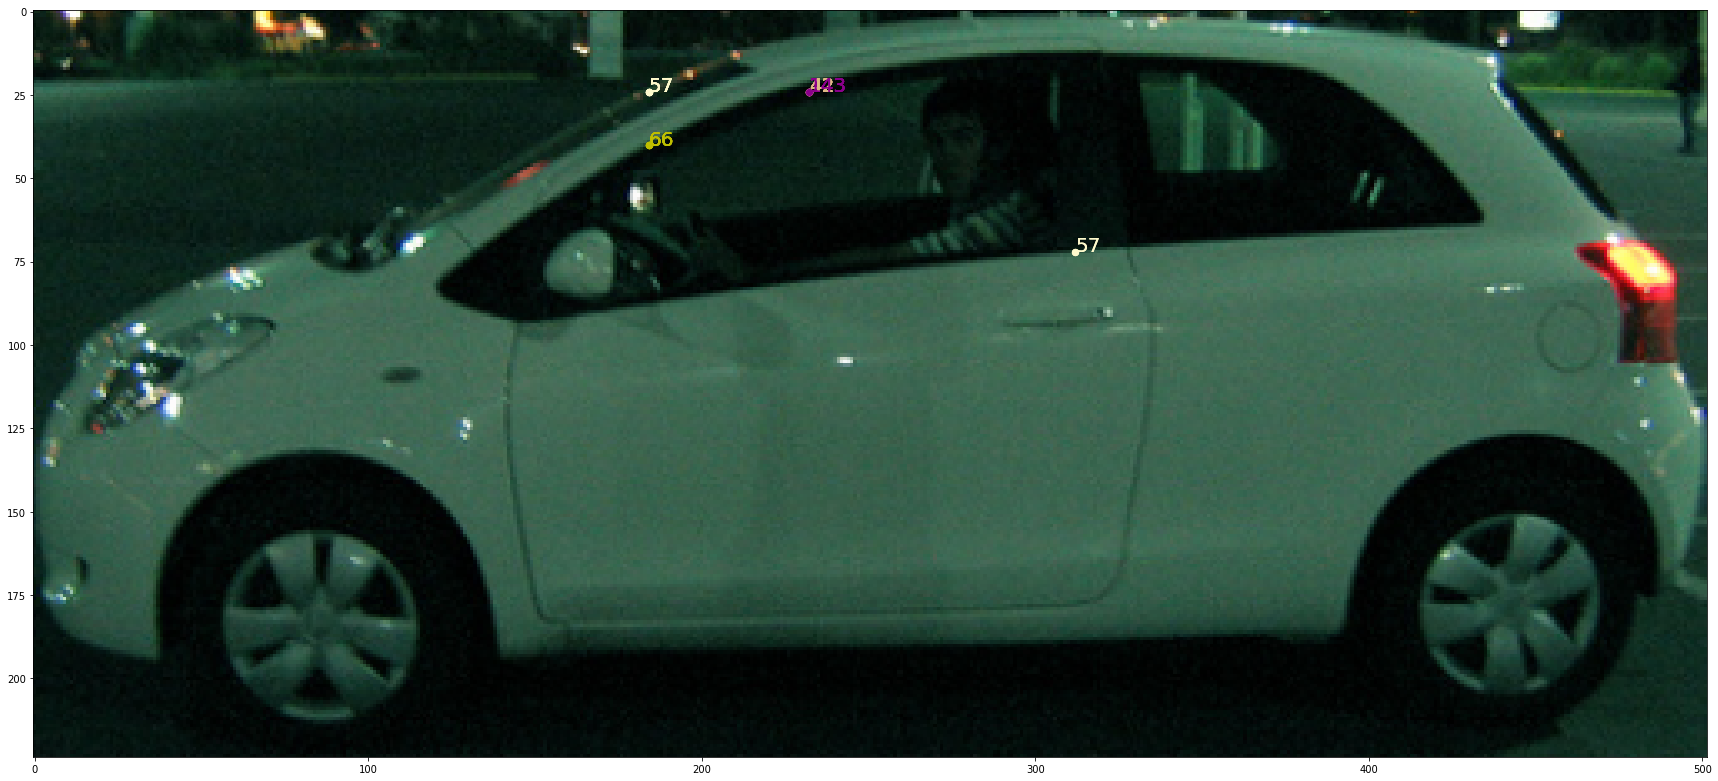

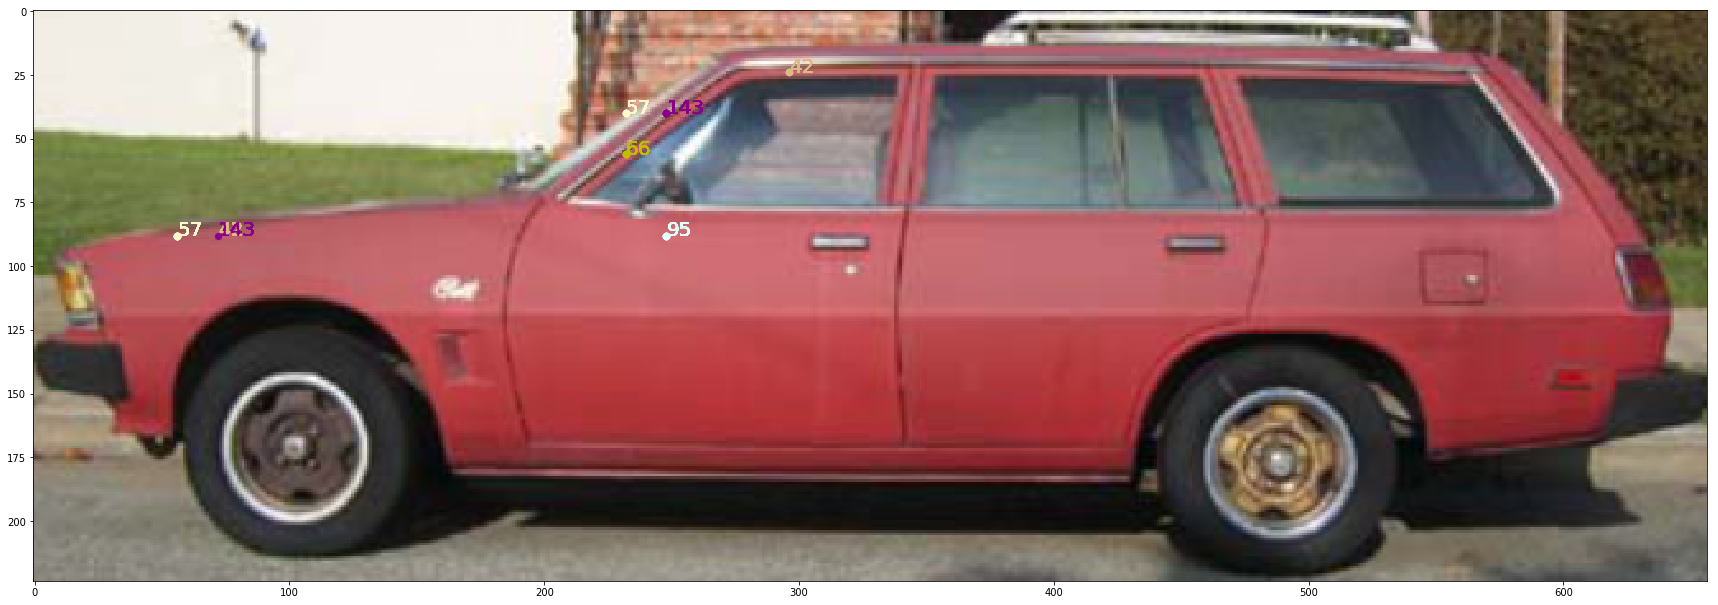

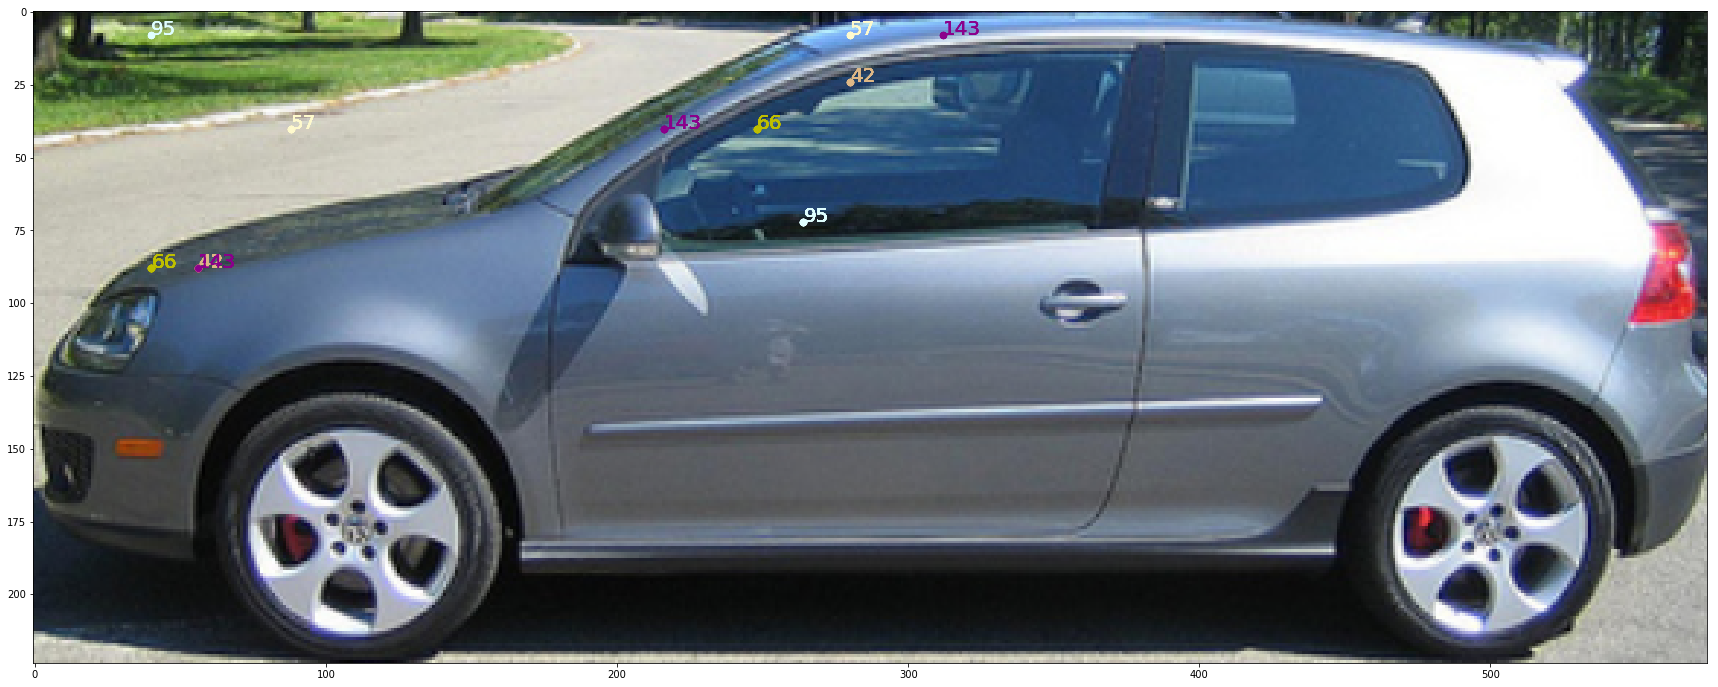

In [81]:
from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgba(color)[:3])), name)
                for name, color in colors.items())
sorted_names = [name for hsv, name in by_hsv]

plt.rcParams['figure.figsize'] = (30.0, 30.0)
# f,ax = plt.subplots(10,1)
for img_i in range(10):
    f,ax = plt.subplots()
    ax.imshow(img_all[img_i][:,:,::-1])
    
    for ri in range(0,max_0-6+1):
        for ci in range(0,max_1-6+1):
            if np.sum(layer_fire_nms[img_i][ri:ri+6, ci:ci+6, vc_ls])>len(vc_ls)/2:
                for vc_i in vc_ls:
                    vc_l = layer_fire_nms[img_i][ri:ri+6, ci:ci+6,vc_i]
                    rii, cii = np.where(vc_l==1)
                    if rii.size==0:
                        continue
                        
                    r_list = Astride * (ri+rii) + Arf/2 - Apad
                    c_list = Astride * (ci+cii) + Arf/2 - Apad
                    for rr in range(len(r_list)):
                        ax.scatter(c_list[rr], r_list[rr], c=colors[sorted_names[vc_i]], s=40)
                        ax.annotate(str(vc_i), (c_list[rr], r_list[rr]), fontsize=20, color=colors[sorted_names[vc_i]])

    plt.show()

# plt.savefig('car_fixV_VC_test_carVC.png')

